In [93]:
# to make tab autocomplete work
%config Completer.use_jedi = False

In [26]:
# imoprt packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [2]:
# read data
dim_pa_claims_rejected = pd.read_csv('../CoverMyMeds_data/dim_pa_claim_rejected.csv')

In [3]:
dim_pa_claims_rejected.head()

,dim_claim_id,bin,drug,reject_code,pharmacy_claim_approved,reject_reason,dim_pa_id,dim_date_id,correct_diagnosis,tried_and_failed,contraindication,pa_approved,Type
0,1,417380,A,75.0,0,In_formulary_needs_PA,1.0,1,1,1,0,1,T2
1,3,417740,A,76.0,0,Limit_exceeded,2.0,1,1,0,0,1,T1
2,10,417380,A,75.0,0,In_formulary_needs_PA,3.0,1,0,0,1,1,T7
3,11,999001,A,76.0,0,Limit_exceeded,4.0,1,1,1,0,1,T2
4,15,417614,A,70.0,0,Not_in_formulary,5.0,1,0,1,0,1,T5


In [243]:
# correlation of features and pa_approved
dim_pa_claims_rejected[['bin','reject_code','correct_diagnosis','tried_and_failed','contraindication','pa_approved']].corr()['pa_approved']

bin                  0.140196
reject_code          0.475336
correct_diagnosis    0.035889
tried_and_failed     0.125490
contraindication    -0.223283
pa_approved          1.000000
Name: pa_approved, dtype: float64

In [87]:
# Seperate dim_pa_claims_rejected into X and y

X = dim_pa_claims_rejected[['bin','drug', 'reject_reason','correct_diagnosis','tried_and_failed','contraindication']]
y = dim_pa_claims_rejected['pa_approved']

In [316]:
# Add new column payer
# convert bin from int to str
X_copy = X.copy()
X_copy['payer'] = ''

X_copy.loc[X_copy.bin==417380, 'payer'] = 'C1'
X_copy.loc[X_copy.bin==999001, 'payer'] = 'C2'
X_copy.loc[X_copy.bin==417740, 'payer'] = 'C3'
X_copy.loc[X_copy.bin==417614, 'payer'] = 'C4'

In [317]:
X_copy.head()

,bin,drug,reject_reason,correct_diagnosis,tried_and_failed,contraindication,payer
0,417380,A,In_formulary_needs_PA,1,1,0,C1
1,417740,A,Limit_exceeded,1,0,0,C3
2,417380,A,In_formulary_needs_PA,0,0,1,C1
3,999001,A,Limit_exceeded,1,1,0,C2
4,417614,A,Not_in_formulary,0,1,0,C4


#### I tried using interaction terms, it did not have any influence on the accuracy/roc_auc of the model.

In [370]:
# One Hot Encoding
X_final = X_copy[['drug','payer','reject_reason','correct_diagnosis','tried_and_failed','contraindication']]
X_enc=pd.get_dummies(X_final, drop_first=True)

In [371]:
X_enc.columns

Index(['correct_diagnosis', 'tried_and_failed', 'contraindication', 'drug_B',
       'drug_C', 'payer_C2', 'payer_C3', 'payer_C4',
       'reject_reason_Limit_exceeded', 'reject_reason_Not_in_formulary'],
      dtype='object')

In [373]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, random_state =42, shuffle = True, test_size = 0.25, stratify = y)

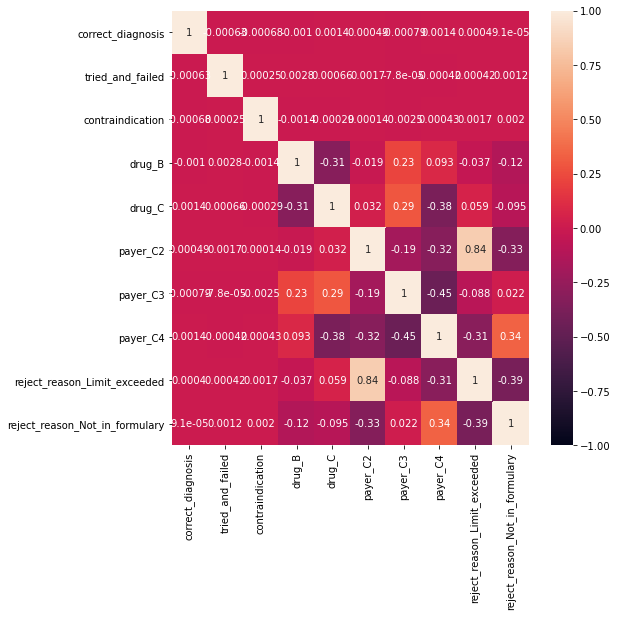

In [374]:
# correlation between features
plt.figure(figsize=(8,8))
heatmap = sns.heatmap(X_train.corr(), vmin=-1, vmax=1, annot=True)

#### There is a strong correlation between payer_C2 and reject_reason_Limit_exceeded. While this makes the inerpretation of the coefficients difficult, it does not affect the predictions of the model.
#### There is a slight anti-correlation between payer_C4 and drug_C, payer_C2, payer_C3. But , i think they can be safely ignored.

In [375]:
# Logistic regression
clf = LogisticRegression(random_state =42, solver = 'lbfgs')

In [376]:
clf.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [377]:
# cross-validation
cv = KFold(n_splits=5, random_state=42, shuffle=True)

# evaluate model
scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.814 (0.001)


In [378]:
clf.coef_

array([[ 0.32491079,  0.91909794, -1.87948933, -0.49387721, -2.09494474,
        -0.13198258, -1.26776408, -0.85547581, -1.61791406, -4.03772117]])

In [379]:
clf.predict_proba([[1,0,0,1,0,0,1,0,1,0]])[0][1]

0.864019839133894

In [380]:
correct_diagnosis = 0
tried_and_failed = 1
contraindication = 1
drug_A = 1
drug_B = 0
drug_C = 0
payer_C1 = 1
payer_C2 = 0
payer_C3 = 0
payer_C4 = 0
reject_reason_In_formulary_needs_PA = 0
reject_reason_Limit_exceeded = 0
reject_reason_Not_in_formulary = 1

arr = np.array([correct_diagnosis, tried_and_failed, contraindication, drug_B,
       drug_C, payer_C2, payer_C3, payer_C4,
       reject_reason_Limit_exceeded, reject_reason_Not_in_formulary])

clf.predict_proba(arr.reshape(1,-1))[0][1]


0.47642218054411883

# Statsmodels
#### To check the significance of the model

In [381]:
import statsmodels.api as sm

In [382]:
model = sm.Logit(endog=y_train, exog=X_train).fit()

Optimization terminated successfully.
         Current function value: 0.437975
         Iterations 7


In [383]:
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:            pa_approved   No. Observations:               416963
Model:                          Logit   Df Residuals:                   416953
Method:                           MLE   Df Model:                            9
Date:                Thu, 20 May 2021   Pseudo R-squ.:                  0.2433
Time:                        12:20:29   Log-Likelihood:            -1.8262e+05
converged:                       True   LL-Null:                   -2.4133e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
correct_diagnosis                  1.4690      0.008    175.036      0.000       1.453       1.485
tried_and_failed                   1.3010      0.008    157.256      0.

In [384]:
print(np.exp(model.params))

correct_diagnosis                 4.344813
tried_and_failed                  3.673089
contraindication                  0.276592
drug_B                            1.464079
drug_C                            0.848628
payer_C2                          4.140193
payer_C3                          1.401828
payer_C4                          4.257624
reject_reason_Limit_exceeded      0.703650
reject_reason_Not_in_formulary    0.071595
dtype: float64
